In [23]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
from IPython.core.debugger import Tracer
from sklearn import datasets, linear_model
#from keras.models import Sequential
#from keras.layers import Dense
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
import seaborn as sns; sns.set()
import operator
import itertools
import matplotlib.patches as mpatches
from scipy.stats.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')
#Tracer()()
def prep (a):
    return a.reshape(a.shape[0], 1)
def unprep (a):
    return np.squeeze(a)

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
#from IPython.core.display import HTML
#HTML("<style> div.code_cell{width: 75%;float: left;}"
#    +"div.text_cell{width: 25%;float: right;}"
#    +"div.text_cell div.prompt {display: none;}</style>")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [4]:
df3 = pd.read_csv('/Users/david/notebooks/data/futs1.csv', header=3)
df3["Date"] = pd.to_datetime(df3["Date"], infer_datetime_format=True)
df3["Date.1"] = pd.to_datetime(df3["Date.1"], infer_datetime_format=True)
df3["Date.2"] = pd.to_datetime(df3["Date.2"], infer_datetime_format=True)
df3 = df3.drop(df3.columns[3], axis=1)
df3 = df3.drop(df3.columns[6], axis=1)
df3.head()

,Date,OPEN,VOLUME,Date.1,OPEN.1,VOLUME.1,Date.2,OPEN.2,VOLUME.2
0,2016-09-01 09:00:00,130.671875,871,2016-09-01 09:00:00,131.13,799.0,2016-09-01 09:00:00,164.40,80.0
1,2016-09-01 09:01:00,130.656250,14,2016-09-01 09:01:00,131.09,400.0,2016-09-01 09:01:00,164.36,14.0
2,2016-09-01 09:02:00,130.656250,103,2016-09-01 09:02:00,131.08,608.0,2016-09-01 09:02:00,164.36,11.0
3,2016-09-01 09:03:00,130.656250,395,2016-09-01 09:03:00,131.04,564.0,2016-09-01 09:03:00,164.35,63.0
4,2016-09-01 09:04:00,130.656250,186,2016-09-01 09:04:00,131.08,211.0,2016-09-01 09:04:00,164.37,17.0


In [5]:
df2 = df3.copy()
df2["CHG"] = df2["OPEN"] - df2["OPEN"].shift(1)
df2["PREVVOLUME"] = df2["VOLUME"].shift(1)
df2["NXTUP"] = df2["CHG"].apply(lambda x: int(1) if x > 0 else int(-1))
df2 = df2.dropna()
df2["LNVOLUME"] = np.log(df2["VOLUME"])
df2["LNVOLUME.1"] = np.log(df2["VOLUME.1"])
df2["LNVOLUME.2"] = np.log(df2["VOLUME.2"])
df2["CHG"] = df2["OPEN"] - df2["OPEN"].shift(1)
df2["CHG.1"] = df2["OPEN.1"] - df2["OPEN.1"].shift(1)
df2["CHG.2"] = df2["OPEN.2"] - df2["OPEN.2"].shift(1)
#df.loc[3:]
#df.head()
#print(df.head())
print(df2.head())
#print(df2["NXTUP"].describe())
df2.groupby('NXTUP').count()

                 Date       OPEN  VOLUME              Date.1  OPEN.1  \
1 2016-09-01 09:01:00  130.65625      14 2016-09-01 09:01:00  131.09   
2 2016-09-01 09:02:00  130.65625     103 2016-09-01 09:02:00  131.08   
3 2016-09-01 09:03:00  130.65625     395 2016-09-01 09:03:00  131.04   
4 2016-09-01 09:04:00  130.65625     186 2016-09-01 09:04:00  131.08   
5 2016-09-01 09:05:00  130.65625    3108 2016-09-01 09:05:00  131.11   

   VOLUME.1              Date.2  OPEN.2  VOLUME.2  CHG  PREVVOLUME  NXTUP  \
1     400.0 2016-09-01 09:01:00  164.36      14.0  NaN       871.0     -1   
2     608.0 2016-09-01 09:02:00  164.36      11.0  0.0        14.0     -1   
3     564.0 2016-09-01 09:03:00  164.35      63.0  0.0       103.0     -1   
4     211.0 2016-09-01 09:04:00  164.37      17.0  0.0       395.0     -1   
5     566.0 2016-09-01 09:05:00  164.38      60.0  0.0       186.0     -1   

   LNVOLUME  LNVOLUME.1  LNVOLUME.2  CHG.1  CHG.2  
1  2.639057    5.991465    2.639057    NaN    NaN  


,Date,OPEN,VOLUME,Date.1,OPEN.1,VOLUME.1,Date.2,OPEN.2,VOLUME.2,CHG,PREVVOLUME,LNVOLUME,LNVOLUME.1,LNVOLUME.2,CHG.1,CHG.2
NXTUP,,,,,,,,,,,,,,,,
-1,21572,21572,21572,21572,21572,21572,21572,21572,21572,21571,21572,21572,21572,21572,21571,21571
1,6246,6246,6246,6246,6246,6246,6246,6246,6246,6246,6246,6246,6246,6246,6246,6246


In [6]:
def calc_e (x, y):
    #Predictor comparison
    res = x - y
    res_e = np.sqrt(np.mean(res**2))
    #print(res_e)
    return res_e, res

In [7]:
def calc_score (x, y):
    #Predictor comparison
    res = x - y
    res_e = np.sqrt(np.mean(res**2))
    #print(res_e)
    return res_e, res

In [8]:
def dumb_p (x1, y1):
    res_e_simple, res_simple = calc_e(unprep(x1), unprep(y1))
    return res_e_simple, res_simple

In [9]:
def prob_move(p, start, end):
    d = dict()
    x1 = p[start:end,:1]
    #print(x1)
    for i in range(0, end-start):
        #just the simple ts
        c1 = x1[i-1] - x1[i]
        if c1[0] not in d:
            d[c1[0]] = 0
        d[c1[0]] +=1
    s = sum(d.values())
    for k in d.keys():
        d[k] = d[k]/s
    #print(d)
    #print(sum(d.values()))
    r = sumproduct(d.keys(), d.values())
    return r, d

In [10]:
def sumproduct(A, B):
    return sum([i*j for i,j in zip(A,B)])

In [11]:
def maxkey(stats):
    return max(stats, key=lambda key: stats[key])

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          axis=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    orig = cm
    if normalize:
        if axis == 1:
            cm = cm.astype('float') / cm.sum(axis=axis)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=axis)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #thresh = cm[i].max() / 2.
        #thresh = orig.sum(axis=axis)[i]*0.5
        thresh = orig.sum()*0.5
        print(i, j, thresh, orig[i,j])
        #col = "black"
        s = "{:1.4f}".format(cm[i,j]) + "("+str(orig[i,j])+")"
        plt.text(j, i, s,
                 horizontalalignment="center",
                 color="white" if orig[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
class GridSeachWithCoef(GridSearchCV):
    @property
    def coef_(self):
        return self.best_estimator_.coef_

In [24]:
def sub_p_svm (x1, y1, x2, y2, do_plot=False):
    #normalise the data
    scaler = StandardScaler()
    x1 = scaler.fit_transform(x1)
    x2 = scaler.transform(x2)
    sv = SVC(kernel='rbf', gamma=0.1)
    useRF = False
    if useRF:
        sv = RandomForestClassifier()
    param_sv = {"C": [1e0, 1e1, 1e2, 1e3],
                        "gamma": np.logspace(-2, 2, 5)}
    param_rf = {"max_depth": [3, None],
              "max_features": [1, 3],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              #"criterion": ["gini", "entropy"]
              "criterion": ["entropy"]
               }
    
    #svc = SVC(kernel="linear", C=1)
    
    #rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
    #rfe.fit(X, y)
    #ranking = rfe.ranking_.reshape(digits.images[0].shape)

    # Plot pixel ranking
    #plt.matshow(ranking, cmap=plt.cm.Blues)
    #plt.colorbar()
    #plt.title("Ranking of pixels with RFE")
    #plt.show()
    tcv = TimeSeriesSplit(n_splits=4)
    svm = GridSearchCV(sv, cv=tcv,
                       param_grid=param_sv)
    
    
    if useRF:
        svm = GridSearchCV(sv, cv=tcv,
                       param_grid=param_rf)
        
    #print(x1)
    #print(y1)
    #print(x2)
    #print(y2)
    #Tracer()()
    #print("mean", x1.mean(axis=0), "std", x1.std(axis=0))

    svm.fit(x1, y1)
    y1_svr = svm.predict(x1)
    y2_svr = svm.predict(x2)
    svm_num = svm.best_estimator_.n_support_
    if useRF:
        svm_num = np.array([0])
    res_e_in = svm.score(x1, y1)
    res_e = svm.score(x2, y2)
    y3 = np.full(len(y2), -1)
    #always do nothing
    res_e_simple = accuracy_score(y2, y3)
    cm = confusion_matrix(y2, y2_svr, labels=[-1, 1])
    cm_simple = confusion_matrix(y3, y2_svr, labels=[-1, 1])
   
    #print(mycm(y2, y2_svr))
    #print(cm)
    
    if do_plot:
        plt.figure()
        plt.clf()
        d = {"-1": "blue", "1":"yellow"}
        c1 = list(map(lambda x : "yellow" if x == -1 else "green", y1))
        patch1 = mpatches.Patch(color='yellow', label='-1 CNG<=0')
        patch2 = mpatches.Patch(color='green', label='+1 CNG>0')
        plt.legend(handles=[patch1, patch2])
        #print(x1[:, 0])
        #print(c1)
        plt.scatter(x1[:, 0], x1[:, 1], c=c1, zorder=10, cmap=plt.cm.Paired)
        #plt.scatter(x2[:, 0], x2[:, 1], s=80, facecolors='none', zorder=10)
        plt.scatter(x2[:, 0], x2[:, 1], s=280, c="k", marker='+', zorder=10, lw=2)

        #plt.axis('tight')
        x_min = x1[:, 0].min()
        x_max = x1[:, 0].max()
        y_min = x1[:, 1].min()
        y_max = x1[:, 1].max()

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = svm.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

        plt.title("svm")#plt.plot(unprep(x1), y1_svr, 'o')
        plt.show()
        #plt.figure()
        #plt.plot(unprep(x2), y2_svr, 'o')
        #plt.figure()
        #plt.plot(res)
        #plt.figure()
        #plt.plot(unprep(x1), label ="X")
        #plt.plot(y1_svr, label ="y_in")
        #plt.legend(loc="best")
        #plt.figure()
        #plt.plot(unprep(x2), label ="X")
        #plt.plot(y2_svr, label ="y_out")
        #plt.legend(loc="best")
    return res_e_in, res_e, res_e_simple, cm, cm_simple, svm_num.mean()

In [14]:
def mycm(actual, predict):
    return pd.crosstab(actual, predict, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [15]:
#--------------------------
# prep the daa
#--------------------------

size = 5000
#w1 = prep(df2["OPEN"].shift(0).values[0:size])
fnum = 2
#labels = ["OPEN", "NXTUP","VOLUME","CHG"]
cols = ["LNVOLUME","LNVOLUME.1","LNVOLUME.2","CHG","CHG.1","CHG.2"]
X = np.transpose([df2[label].shift(i).values[fnum:size+fnum]  for i in range(fnum) for label in cols])
y = df2["NXTUP"].shift(-1).values[fnum:size+fnum]
print(np.shape(X), np.shape(y))
X
#print(X[4])
#print(X)
#print(y)
#print(np.shape(np.transpose(X)))
#y = prep(df2["OPEN"].shift(-1).values[0:size])
#print(np.shape(d))
#for i in range(np.shape(d)[0]):
#    plt.plot(d[i])
#    print(d[i])

(5000, 12) (5000,)


array([[ 5.97888576,  6.33505425,  4.14313473, ...,  0.        ,
        -0.01      ,  0.        ],
       [ 5.22574667,  5.35185813,  2.83321334, ...,  0.        ,
        -0.04      , -0.01      ],
       [ 8.04173471,  6.33859408,  4.09434456, ...,  0.        ,
         0.04      ,  0.02      ],
       ..., 
       [ 7.78280726,  6.06378521,  7.58273849, ...,  0.015625  ,
        -0.02      , -0.03      ],
       [ 6.79122146,  5.03043792,  7.55642797, ..., -0.015625  ,
         0.01      , -0.01      ],
       [ 5.14166356,  4.8598124 ,  7.19818358, ...,  0.        ,
        -0.01      ,  0.        ]])

In [16]:
#np.array([1, 1, 2, 2])
#df2["NXTUP"].shift(-1).values[fnum:size+fnum]

500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2110, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2200, 2210, 2220, 2230, 2240, 

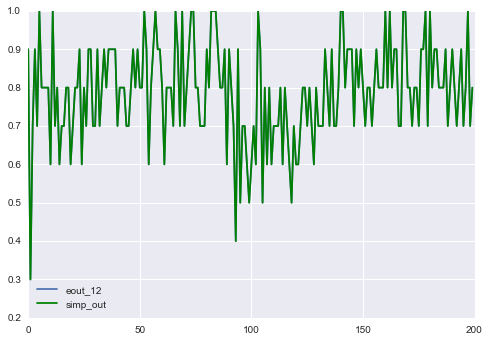

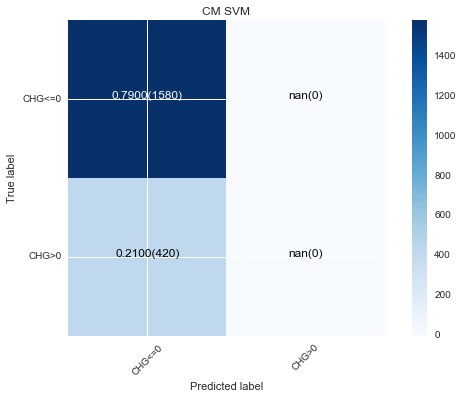

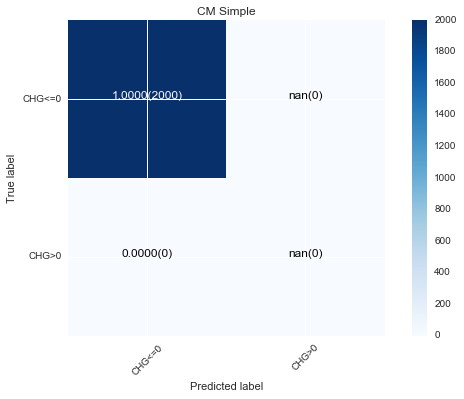

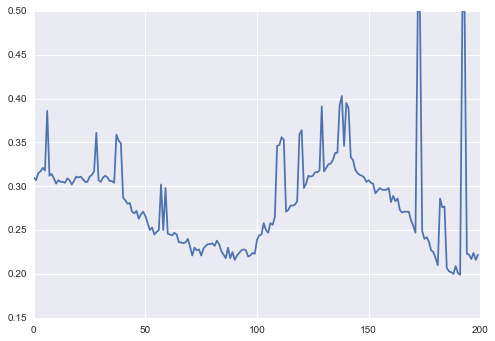

In [27]:
#----------------------------------------
# Main Work
#----------------------------------------
step = 10
train_len = 500
test_len = step

#last val as pred for next val
#s1, res_s = dumb_p(X[:train_len, 0], y[:train_len])
#s2, res_s = dumb_p(X[train_len:, 0], y[train_len:])
#Tracer()()
#f = 1
start_train = 0
end_train = start_train + train_len
e_out_ar = []
e_in_ar =[]
e_simple_ar = []

b1_ar = []
cm_ar = []
cm_simple_ar = []
svm_num_ar = []
it = 0
max = 200
while end_train < len(X):
    if it >= max:
        break
    end_train = np.min([start_train + train_len, len(X)])
    end_test = end_train + test_len
    l1 = len(X) - end_train
    if l1 ==0:
        break
    #do stuff
    for f in [fnum*len(cols)]:
        #print(X[start_train:end_train,:f].shape)
    
        e_in, e_out, e_simple, cm, cm_simple, svm_num = sub_p_svm(X[start_train:end_train,:f], y[start_train:end_train], 
                            X[end_train:end_test,:f], y[end_train:end_test], do_plot=False)
        e_in_ar.append(e_in)
        e_out_ar.append(e_out)
        e_simple_ar.append(e_simple)
        cm_ar.append(cm)
        cm_simple_ar.append(cm_simple)
        svm_num_ar.append(svm_num)
    #s3, res_s = dumb_p(X[start_train:end_train, 0], y[start_train:end_train])
    #s4, res_s = dumb_p(X[end_train:end_test, 0], y[end_train:end_test])
    #s3_ar.append(s3)
    #s4_ar.append(s4)
    #s3_ar.append(0.5)
    #s4_ar.append(0.5)
    
    #b_dict = prob_move(X, start_train, end_train)
    print (end_train, end=", ")
    #print(e_in, e_out)
    start_train += step
    it += 1
    
plt.figure()
plt.plot(e_out_ar, label='eout_'+str(f))
plt.plot(e_simple_ar, label="simp_out", color = 'g')
plt.legend(loc='best')

plt.figure()
#print(cm_ar)
#print([cm_ar[i][0,0] for i in range(len(cm_ar))])
up_right = np.array([cm_ar[i][1,1] for i in range(len(cm_ar))])
up_wrong = np.array([cm_ar[i][0,1] for i in range(len(cm_ar))])
#up_per = np.nan_to_num(up_right / (up_right + up_wrong))
up_per = up_right / (up_right + up_wrong)

tot = [np.sum([cm_ar[i][y,x] for i in range(len(cm_ar))]) for y in range(2) for x in range(2)]
tot1 = np.array(tot).reshape(2, 2)
tot_simple = [np.sum([cm_simple_ar[i][y,x] for i in range(len(cm_simple_ar))]) for x in range(2) for y in range(2)]
tot1_simple = np.array(tot_simple).reshape(2, 2)
labels = ['CHG<=0','CHG>0']
#print(tot)
plot_confusion_matrix(tot1, labels, normalize=True, title ="CM SVM")
plot_confusion_matrix(tot1_simple, labels, normalize=True, title ="CM Simple")
plt.figure()
plt.plot(np.array(svm_num_ar)/train_len)
plt.plot(up_per, 'o')
#tot[0,1] = [cm_ar[i][0,1] for i in range(len(cm_ar))]
#tot[1,0] = [cm_ar[i][1,0] for i in range(len(cm_ar))]
#tot[1,1] = [cm_ar[i][1,1] for i in range(len(cm_ar))]
#plt.figure()
#plt.plot(e_in_ar, label="ein")
#plt.plot(s3_ar, label="simp_in", color = 'g')
#plt.legend(loc='best')


In [18]:
pl = np.array(svm_num_ar)/train_len
res1 = []
res2 = []
for i in range(len(up_per)):
    if not np.isnan(up_per[i]):
        res1.append(up_per[i])
        res2.append(pl[i])
print(res1)
print(res2)
pearsonr(res1, res2)[0]



[0.5, 0.0, 1.0, 1.0, 0.5, 0.5, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.20000000000000001, 0.16666666666666666, 1.0]
[0.29499999999999998, 0.40000000000000002, 0.28499999999999998, 0.40500000000000003, 0.28999999999999998, 0.27000000000000002, 0.25, 0.255, 0.245, 0.26500000000000001, 0.31, 0.26500000000000001, 0.41999999999999998, 0.46000000000000002, 0.44500000000000001, 0.44500000000000001, 0.34499999999999997]


-0.17607038656022442

In [19]:
a1 = [-1, 1, -1]
a2 = map(lambda x : "yellow" if x == -1 else "green", a1)
print(list(a2))
print(plt.cm.Paired)
np.array([0]).mean()

['yellow', 'green', 'yellow']


0.0

In [20]:
a = 0.99923
b = 234
s = "{:1.4f}".format(a) + "("+str(b)+")"
s
y3 = np.full(4, -1)
print(y3)

[-1. -1. -1. -1.]
